# EZH1

EZH1-related disorders were not listed in OMIM at the time of this writing (2024-09-26). A publication from 2023 describes "Gain and loss of function variants in EZH1 disrupt neurogenesis and cause dominant and recessive neurodevelopmental disorders" ([Gracia-Diaz et al., 2023](https://pubmed.ncbi.nlm.nih.gov/37433783/)). The authors  identified 

> biallelic truncating and heterozygous missense EZH1 variants in 19 individuals with varying degrees of developmental, language and motor delays, mild to severe intellectual disability and dysmorphic facial features.

Furthermore, the authors demonstrated that

>  EZH1 variants cause recessive loss of function (LOF) or dominant gain of function (GOF) effects.

Therefore, we endeavored to test whether there are significant differences in the phenotypic features of these two groups.

We note that we record the disease diagnosis of all individuals as
OMIM:601674 (the identifier for the EZH1 gene), and "EZH1-related neurodevelopmental disorder".

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


## EZH1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ASPM.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'EZH1'
mane_tx_id = 'NM_001991.5'
mane_protein_id = 'NP_001982.2' # histone-lysine N-methyltransferase EZH1 isoform 1
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 19 phenopackets
Individuals Processed: 100%|██████████| 19/19 [00:03<00:00,  6.12 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
19,Delayed fine motor development
17,Delayed speech and language development
16,Delayed gross motor development
15,Intellectual disability
9,Delayed early-childhood social milestone development
8,Hypotonia
7,Postural instability
6,Aggressive behavior
5,Dysmetria
3,Autism


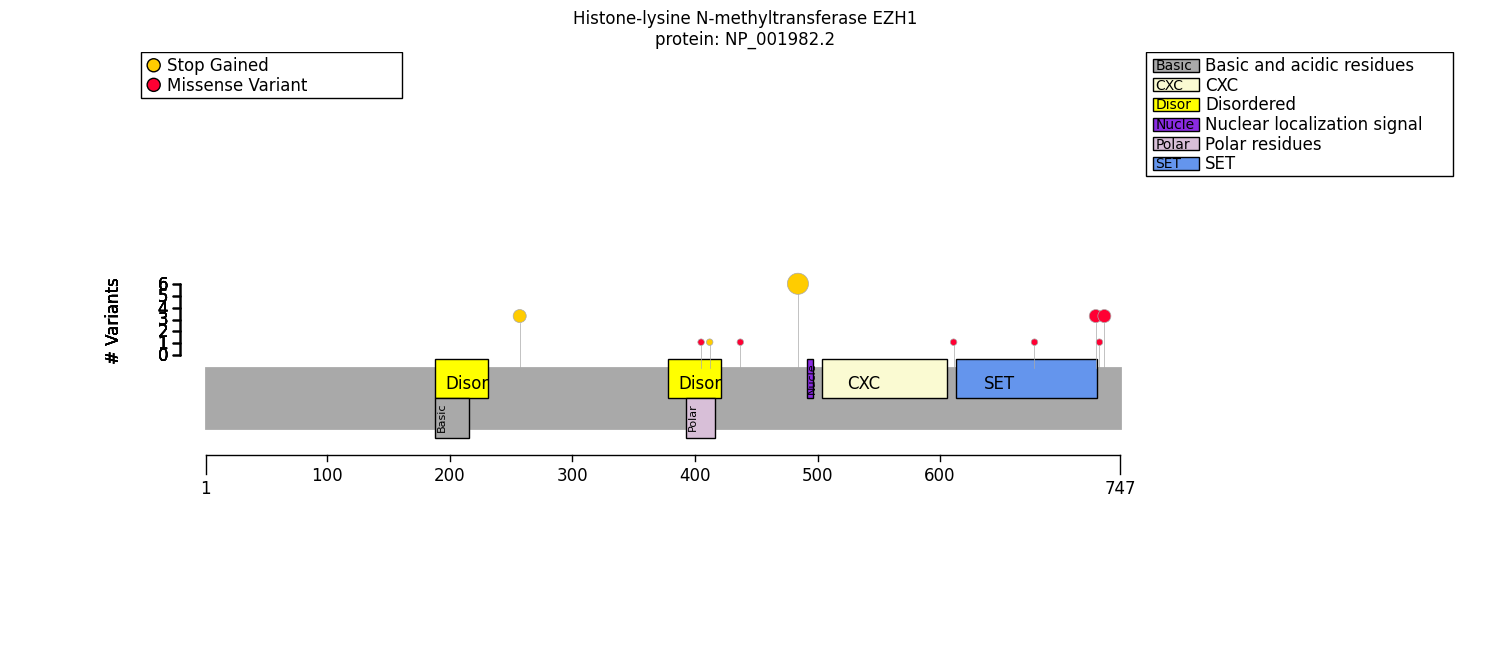

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

ezh1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
ezh1_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.analysis.clf import allele_count
from gpsea.analysis.predicate import gene
from gpsea.view import MtcStatsViewer

ezh1 = gene(symbol="EZH1")

count_clf = allele_count(counts=({1,}, {2,}), target=ezh1)
count_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=count_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(count_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,15
HMF03,Skipping term because of a child term with the same individual counts,6
HMF08,Skipping general term,62
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,199


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=count_result)

Allele count,1 allele,2 alleles,Corrected p values,p values
Aggressive behavior [HP:0000718],3/7 (43%),3/4 (75%),1.0,0.545455
Hypotonia [HP:0001252],6/9 (67%),3/7 (43%),1.0,0.614510
Delayed gross motor development [HP:0002194],10/10 (100%),9/9 (100%),1.0,1.000000
Motor delay [HP:0001270],10/10 (100%),9/9 (100%),1.0,1.000000
Neurodevelopmental delay [HP:0012758],10/10 (100%),9/9 (100%),1.0,1.000000
Neurodevelopmental abnormality [HP:0012759],10/10 (100%),9/9 (100%),1.0,1.000000
Delayed speech and language development [HP:0000750],10/10 (100%),9/9 (100%),1.0,1.000000
Abnormal communication [HP:0034434],10/10 (100%),9/9 (100%),1.0,1.000000
Intellectual disability [HP:0001249],10/10 (100%),9/9 (100%),1.0,1.000000
Delayed fine motor development [HP:0010862],10/10 (100%),9/9 (100%),1.0,1.000000


In [9]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=count_result,
    ),
)

ezh1_caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=ezh1_caption)
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
1 allele,2 alleles,22,0


In [10]:
summarizer.process_latex(report=report, protein_fig=ezh1_fig)

Figure saved to ../../supplement/img/EZH1_protein_diagram-draft.pdf
Output to ../../supplement/tex/EZH1_summary_draft.tex
